## Linear Regression with Time Series Data

In [51]:
import matplotlib.pyplot as plt 
import pandas as pd 
import plotly.express as px 
import pytz 
from pymongo import  MongoClient 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 

### Prepare Data

In [ ]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    df = pd.DataFrame(results).set_index("timestamp")
    
    # Localize time zone
    df.index= df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    # Remove Outlines
    df = df[df["P2"] < 500]
    
    # Resample
    df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()
    
    # Add lag feature
    df["P2.L1"]=df["P2"].shift(1)
    
    # Drop NaN rows
    df.dropna(inplace=True)
    
    return df

In [52]:
# Import data
df = pd.read_csv("data/nairobi-city-air-quality.csv")
df.head()

,timestamp,P2
0,09/01/2018 00:00,34.43
1,09/01/2018 00:05,30.53
2,09/01/2018 00:10,22.80
3,09/01/2018 00:15,13.30
4,09/01/2018 00:20,16.57


Localize time Zone by completing the wrangle function:

In [53]:
df = df.set_index("timestamp")
df.head()

,P2
timestamp,
09/01/2018 00:00,34.43
09/01/2018 00:05,30.53
09/01/2018 00:10,22.80
09/01/2018 00:15,13.30
09/01/2018 00:20,16.57


In [ ]:
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

Connect to Database

In [ ]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
nairobi = db["nairobi"]

#### Explore

PM2.5 Boxplot

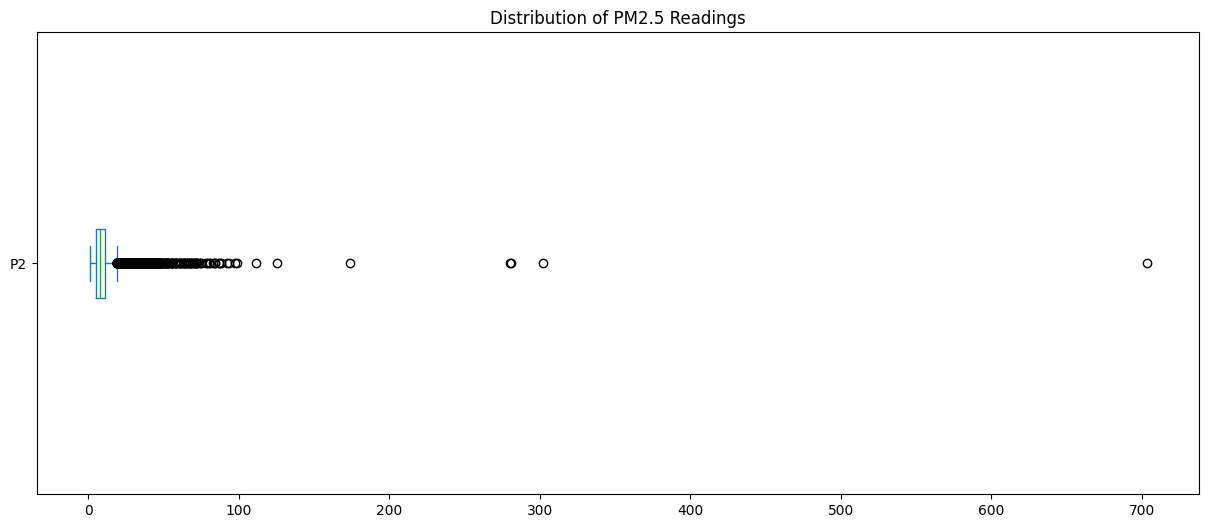

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);

Remove outliers by dropping reading above 500 from the dataset.

In [56]:
 df = df[df["P2"] < 500]
 df.head()

,P2
timestamp,
09/01/2018 00:00,34.43
09/01/2018 00:05,30.53
09/01/2018 00:10,22.80
09/01/2018 00:15,13.30
09/01/2018 00:20,16.57


In [57]:
# Assert outlier removal
assert len(df) <= 32906

Creating a time series plot:

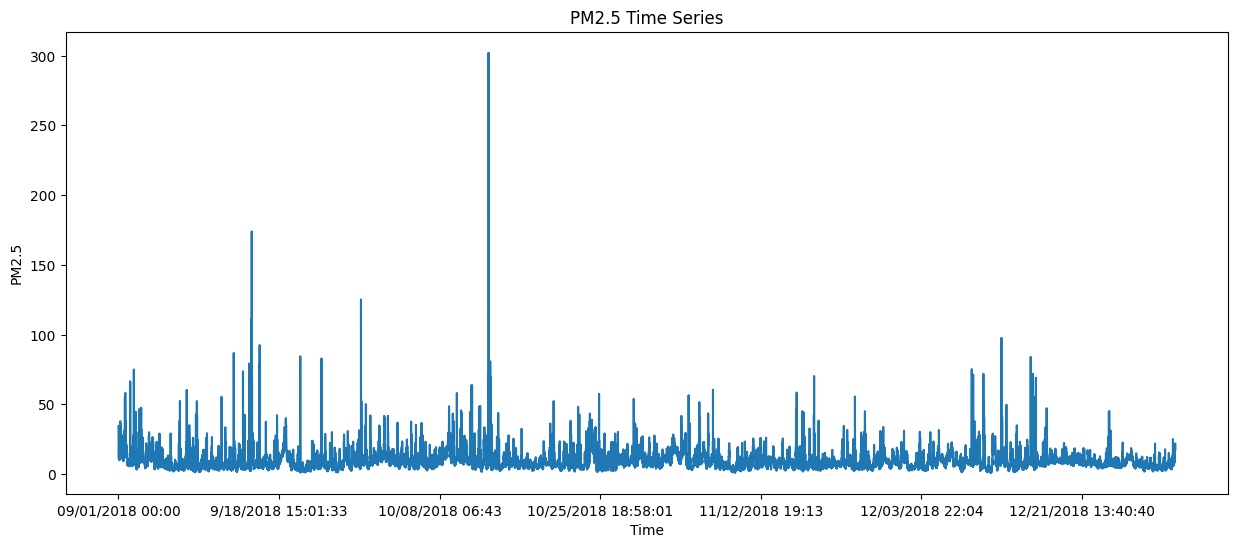

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(ax=ax, xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series");

Resample Time Series to give the mean of "P2" reading for each hour by modify the wrangle function.

In [27]:
#df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

Rolling Average of the "P2" readings in df:

In [59]:
df["P2"].rolling(168).mean().to_frame().tail()

,P2
timestamp,
12/31/2018 23:35:06,8.182917
12/31/2018 23:40:06,8.274464
12/31/2018 23:45:05,8.355119
12/31/2018 23:50:05,8.434762
12/31/2018 23:55:05,8.499048


Plotting the Rolling averages:

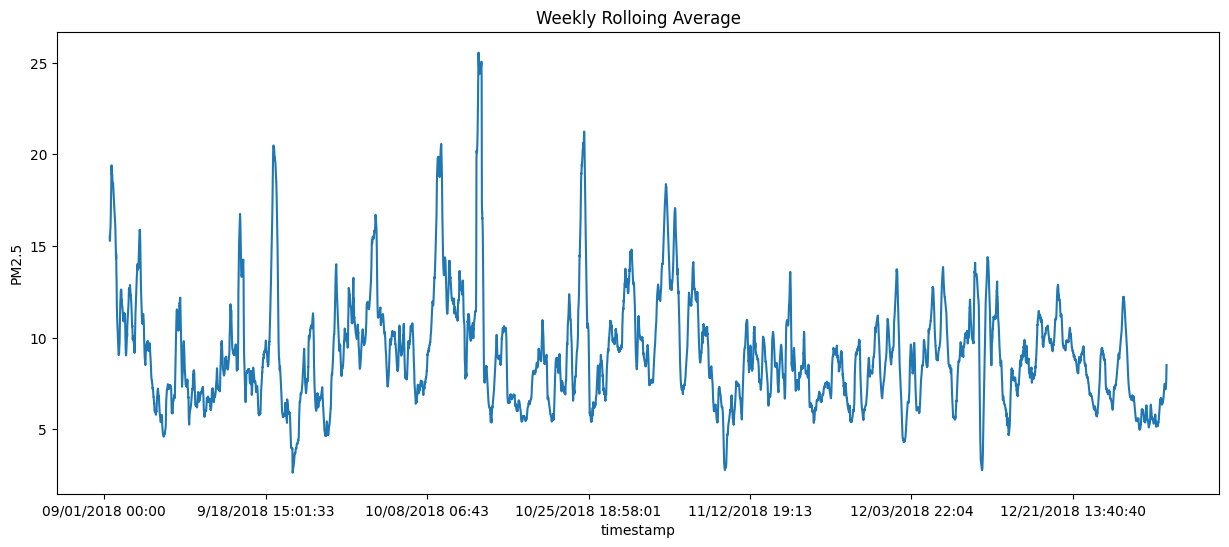

In [60]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].rolling(168).mean().plot(ax=ax, ylabel="PM2.5", title="Weekly Rolloing Average");

Create lag Feature by modifying the wrangle function to create the column "P2.L1" that contains the mean "p2" reading from the previous hour:

In [63]:
    # Add lag feature
    df["P2.L1"]=df["P2"].shift(1)

Drop NaNs:

In [64]:
    # Drop NaN rows
    df.dropna(inplace=True)
    df.head()

,P2,P2.L1
timestamp,,
09/01/2018 00:05,30.53,34.43
09/01/2018 00:10,22.80,30.53
09/01/2018 00:15,13.30,22.80
09/01/2018 00:20,16.57,13.30
09/01/2018 00:25,14.07,16.57


Correlation Matrix:  Autocorelation

In [65]:
df.corr()

,P2,P2.L1
P2,1.000000,0.763088
P2.L1,0.763088,1.000000


Autocorelation plot: A scatter plot that shows PM 2.5 mean reading for each hour as a function of the mean reading from the previous hour.

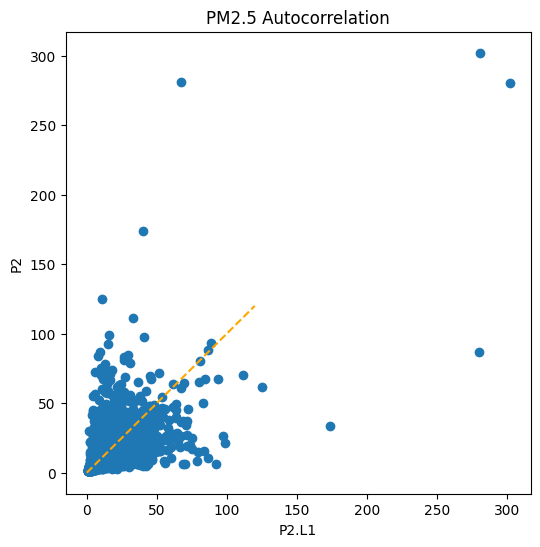

In [66]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["P2.L1"], y = df["P2"])
ax.plot([0,120], [0,120], linestyle="--", color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Autocorrelation");

#### Split

Vertical split

In [67]:
target = "P2"
y = df[target]
X = df.drop(columns=target)

In [68]:
y.head()

timestamp
09/01/2018 00:05    30.53
09/01/2018 00:10    22.80
09/01/2018 00:15    13.30
09/01/2018 00:20    16.57
09/01/2018 00:25    14.07
Name: P2, dtype: float64

In [69]:
X.head()

,P2.L1
timestamp,
09/01/2018 00:05,34.43
09/01/2018 00:10,30.53
09/01/2018 00:15,22.80
09/01/2018 00:20,13.30
09/01/2018 00:25,16.57


Split X amd y into training and test sets, with the first 80% of the data being in the training set and the remaining in the test set.

In [70]:
cutoff=int(len(X) * .8)
len(X.iloc[cutoff:])

6581

In [71]:
cutoff = int(len(X) * .8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]
print((len(X_train)))

26324


### Build Model

#### Baseline Model

In [72]:
y_pred_baseline = [y_train.mean()] * len(X_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.28
Baseline MAE: 4.26


#### Iterate

In [73]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Evalaute Model

In [74]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 1.89
Test MAE: 1.59


### Communicate Results

Extracting coefficient and intercept from the model:

In [75]:

intercept = round(model.intercept_, 2)
coefficient = model.coef_.round(2)[0]

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 2.12 + (0.77 * P2.L1)


Prediction dataFrame

In [76]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
12/08/2018 13:14,5.20,10.218856
12/08/2018 13:19,5.60,6.133065
12/08/2018 13:24,5.15,6.441427
12/08/2018 13:29,3.83,6.094520
12/08/2018 13:34,3.62,5.076927


Plot Time Series Predictions

In [77]:
fig = px.line(df_pred_test, labels={"value":"P2"})
fig.show()